在第5章中，我们学习了卷积神经网络，以及它们在计算机视觉问题上的优异表现，由于它们具有“卷积”运算，可以从一部分输入中提取特征，并能构将表示模块化，同时地可以高效的利用数据。这些使得卷积网络在计算机视觉上优异的特点同样令它们可以应用在序列处理之上。实际上，时间可以作为空间的一个维度，就像2D图像的高度和宽度一样。

这些性质使得卷积网络在计算机视觉上优异的特点同样令它们可以应用在序列处理之上。实际上，时间可以作为空间的一个维度，就像2D图像的高度和宽度一样。

### 6.4.1 理解序列数据的一维卷积

前面介绍的卷积层都是二维卷积，从图像张量中提取二维图块应用相同的变换。按照同样的方法，你也可以使用一维卷积，从序列中提取局部一维序列段（即子序列）。
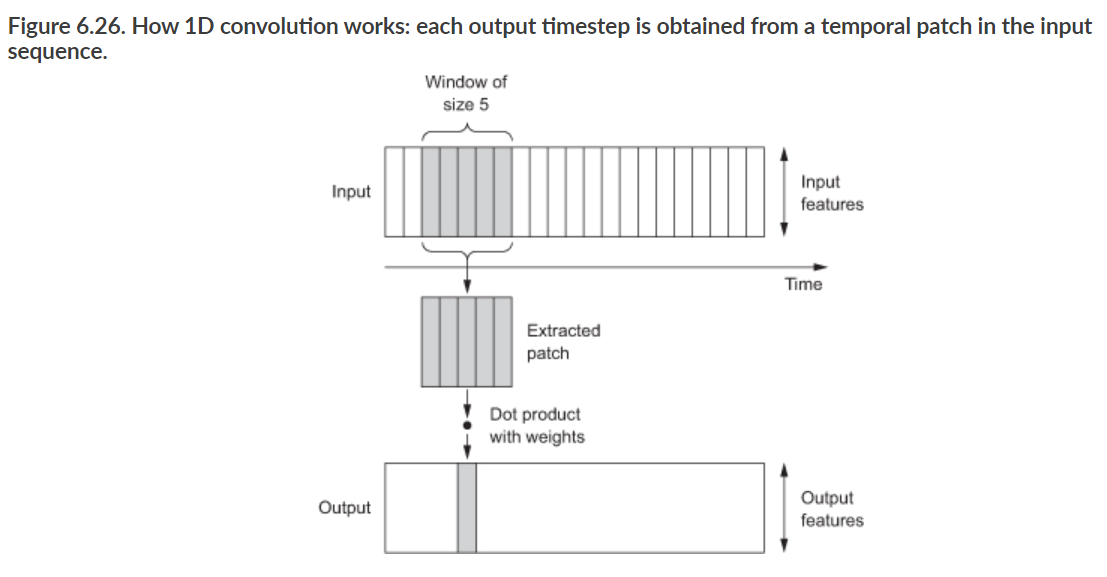
图6-26  一维卷积神经网络的工作原理：每个输出时间步都是利用输入序列在时间维度上的一小段得到的。

这样的1D卷积层能够识别序列数据中的局部模式。因为所有提取的局部片段都应用了相同的转换操作，因此在一个句子中某个位置学习到的模式能够后续在不同的位置上识别出来，这使得1D卷积网络具有平移不变性（对于时间转换来说）。例如，一个使用卷积窗口尺寸5的1D卷积网络能够在句子中学习到长度为5或一下的单词或单词片段，然后就可以将这些学习到的单词应用到输入序列的任何地方。所以字符级别的1D卷积网络能够学习到词法的知识。

### 6.4.2 对序列数据使用一维池化

你应该已经熟悉二维池化运算了，比如二维平均池化或最大池化，它们用于在卷积网络中对图像张量空间进行下取样。同样二维池化操作也有着一维的版本，用来从一维的局部特征（子序列）中提取最大值（“最大池化”）或平均值（“平均池化”）。与二维卷积网络一样，一维池化用来缩减一维输入序列的长度（“子采样”）。

### 6.4.3 实现一个1D卷积网络

在Keras中你可以通过Conv1D来定义一维卷积网络，它有着与Conv2D非常相似的接口。Conv1D接收的输入是一个形状为(samples, time, features)的三维张量，返回类似形状的三维张量。其中的卷积窗口是对时间轴上的一维窗口。

下面我们来构建一个简单的两层1D卷积网络，用它来尝试解决IMDB情绪分析任务。作为一个复习，下面的代码是数据获取及预处理的过程：

In [15]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

max_len, max_features = 500, 10000

print('Loading data....')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train_sequences')
print(len(y_train), 'train_sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print(x_train.shape, 'x_train shape')
print(x_test.shape, 'x_test.shape')

Loading data....
25000 train_sequences
25000 train_sequences
Pad sequences (samples x time)
(25000, 500) x_train shape
(25000, 500) x_test.shape


一维卷积网络的架构与第五章二维卷积神经网络是一样的：它们是Conv1D和MaxPooling1D层的堆叠，最后是一个全局池化层或者一个Flatten层，将三维输出转换成二维输出，然后就可以增加一个或多个Dense层，用来进行分类或回归。

不过有一个区别，那就是我们可以在一维卷积网络中使用一个更大的卷积窗口。实际上在二维卷积层中，一个3x3的卷积窗口包含着`3*3 = 9`的特征向量，但是在一个一维卷积层中，一个大小为3的卷积窗口仅包含3个特征向量。我们可以很自然的使用大小为7或9的卷积窗口。

下面就是我们在IMDB数据集上使用1D卷积网络的例子：

In [16]:
#在imdb数据集上训练并评估一个简单的一维卷积神经网络
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPool1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(1))

model.summary()

model.compile(RMSprop(learning_rate = 1e-4), 'binary_crossentropy', 'accuracy')

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_11 (Conv1D)          (None, 494, 32)           28704     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                

将上面的网络结构可视化：
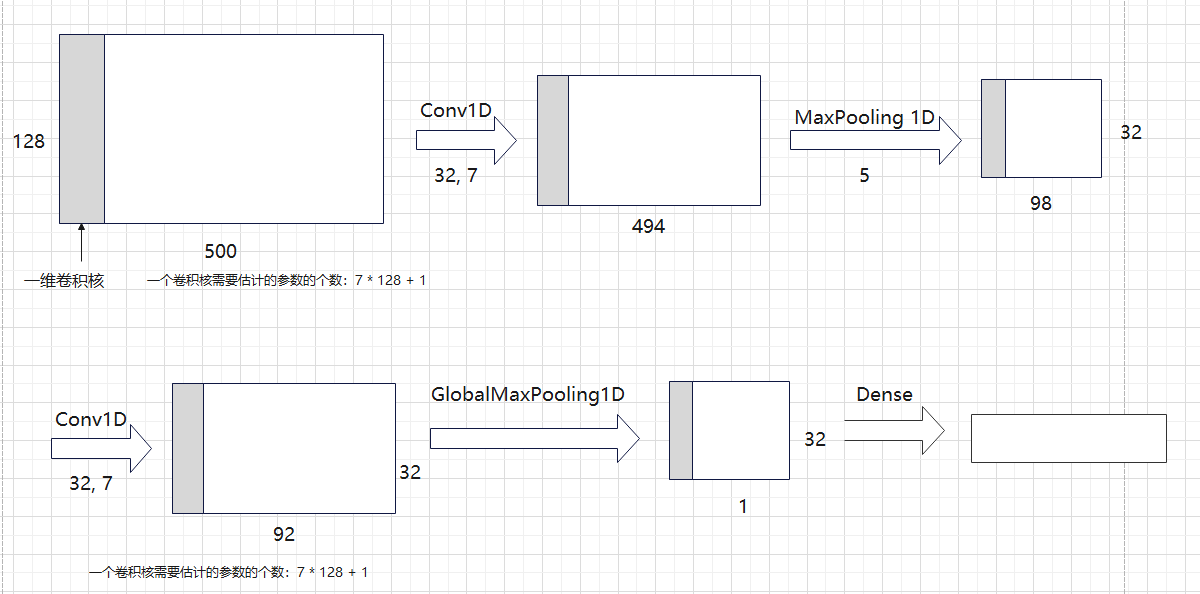

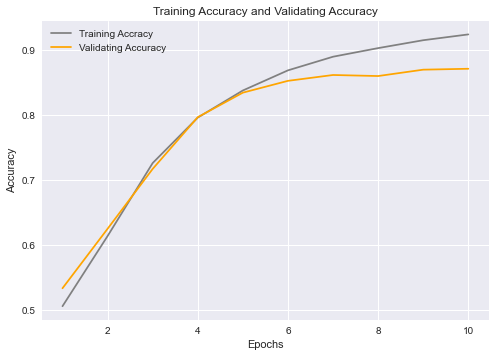

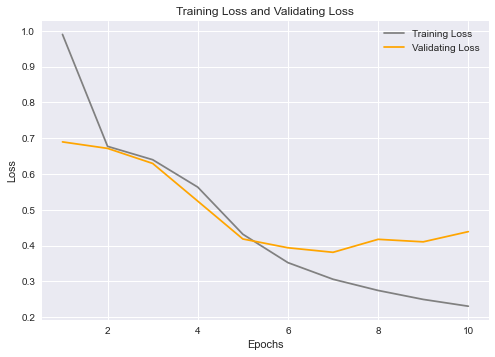

In [17]:
#绘制训练精度和验证精度
import  matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.style.use('seaborn')
plt.plot(epochs, acc, 'grey', label = 'Training Accracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validating Accuracy')
plt.title('Training Accuracy and Validating Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'grey', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
print('max value of val_acc', max(val_acc))
print('min value of val_loss', min(val_loss))

max value of val_acc 0.8712000250816345
min value of val_loss 0.38114017248153687


In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(test_loss, test_acc)

782/782 [==============================] - 4s 5ms/step - loss: 0.4599 - accuracy: 0.8651
0.45985147356987 0.865119993686676


上面看到了训练和验证的结果：验证准确率比起前面的LSTM模型要低，但是运行时间更快，无论是在CPU还是GPU上（尽管节省的时间与准确的配置相关）。根据结果，我们可以使用正确的8轮epochs来重新训练我们的模型，然后将它应用到测试集上。这个实验可以证明在单词级别的情绪分类任务上，一维积网络能够提供一个比循环网络更加快速和便宜的替代。

### 6.4.4 结合CNN和RNN来处理长序列
一维卷积神经网络分别处理每个输入序列段，所有它对时间步的顺序不敏感（这里收的时间范围要大于局部尺度，即大于卷积窗口的大小），这一点与RNN不同。当然为了识别更长的序列段，你可以将许多卷积层和池化层堆叠在一起，这样上面的层可以观察到原始输入中更长的序列段，但这仍不是一种引入顺序敏感性的好方法。  
想要证明这种方法性的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。  
下面重新导入温度预测问题上相关的变量：float_data、train_gen、val_gen、val_steps

In [5]:
import os

filename = 'D:\\Download\\jena_climate_2009_2016.csv\\jena_climate_2009_2016.csv'

with open(filename) as f:
    data = f.read()
    f.close()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    value = [ float(x) for x in line.split(',')[1:] ]
    float_data[i, :] = value
    
#数据标准化
mean = float_data[: 200000].mean(axis = 0)
std = float_data[: 200000].std(axis = 0)

float_data -= mean
float_data /= std

In [6]:
#5、生成事件序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data)- delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size = batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))

        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets    

In [7]:
#6、准备训练数据、验证数据和测试数据生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                      shuffle = True, step = step, batch_size = batch_size)

val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                    step = step, batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300000, max_index = None,
                    step = step, batch_size = batch_size)

# 为了查看整个验证数据集需要从val_gen中抽取的次数
val_steps = (300000 - 200001 - lookback) // batch_size

# 为了查看整个测试数据集需要从test_gen中抽取的次数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
#在耶拿数据上训练并评估一个简单的一维卷积神经网络
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(1))
model.summary()

model.compile('RMSprop', 'mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)              

In [9]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

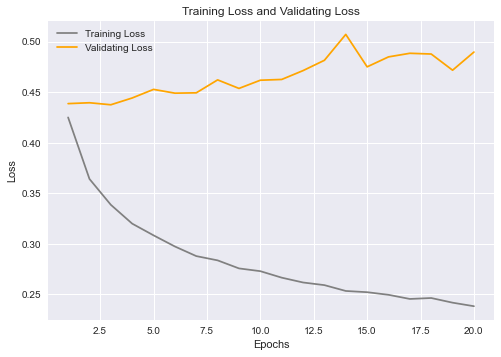

In [10]:
import  matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'grey', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


验证MAE保持在0.4-0.5附近：我们使用小型卷积网络甚至都无法击败常识性基准方法。这是因为卷积网络会在输入的时间序列局部寻找模式，但是却无法获得任何关于这个模式处于哪个时间位置的信息（比方说在开始时间或者末尾等）。因为在这个任务重，最近的数据点应该和更早期的数据点具有不同的诠释，所以卷积网络无法在这种情况下获得有意义的结果。卷积网络的这种限制不会体现在IMDB数据集上，是因为评论中的一些关键字对于正向还是负向情绪的影响与其在句子中的位置是相对无关的。

有一种策略能够将卷积网络的轻量特点和RNN的顺序敏感特点结合起来，那就是使用1D卷积网络作为RNN的数据预处理步骤。这个方法在处理那种特别长的无法实际应用RNN的时间序列情况下特别适用，例如，处理一二具有上千步的序列。卷积网络能够通过降取样方法将很长的输入序列转换成具有更高层特征的短序列。然后将这些提取到的特征序列作为RNN部分的输入。

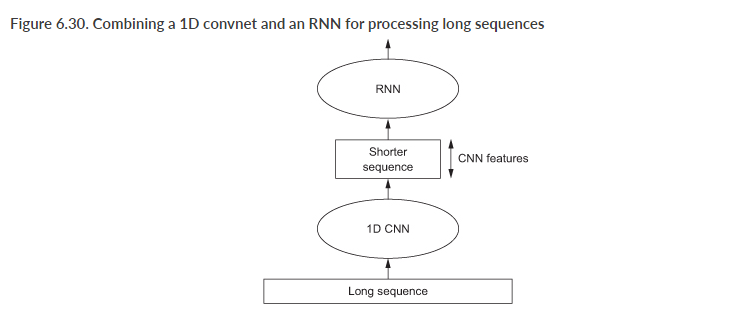

图6-30 结合一维CNN络和RNN来处理长序列

这种方法在研究论文和实践应用中并不常见，可能因为它还未普及。但它是很有效的，应该为更多人知悉。下面我们将它应用到气温预测数据集上。因为这个策略允许我们操作更加长的序列，我们既可以查看更加久远的数据（通过增加数据生成器的lookback参数），也可以使用更加精细采样的时间序列（通过减小生成器的step参数）。下面我们选择（带有随意性）使用将step参数减半，这样能够获得两倍长度的时间序列，也就是气象数据会使用每30分钟采样一次的频率。

In [11]:
#为耶拿数据集准备更高分辨率的数据生成器
step , lookback, delay = 3, 720, 144

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000,
                      shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300000, max_index=None,
                     step=step, batch_size=batch_size)

# 为了查看整个验证数据集需要从val_gen中抽取的次数
val_steps = (300000 - 200001 - lookback) // batch_size

# 为了查看整个测试数据集需要从test_gen中抽取的次数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

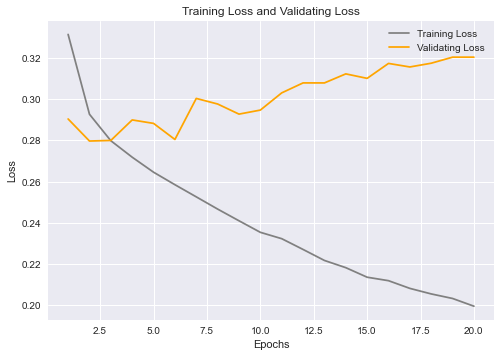

In [13]:
#结合一维卷积基和GRU层的模型
from keras.layers import GRU, LSTM

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.summary()
model.compile(RMSprop(), 'mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

import  matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'grey', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          5152      
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,777
Trainable params: 15,777
Non-trainable params: 0
__________________________________________________

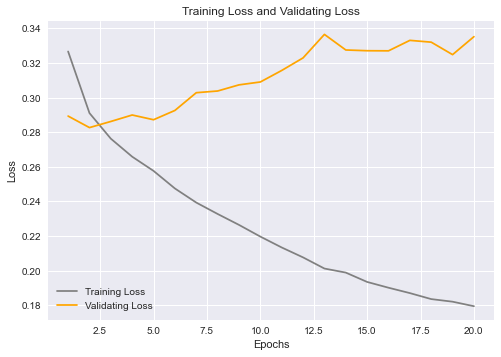

In [14]:
#结合一维卷积基和LSTM层的模型
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPool1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.summary()
model.compile(RMSprop(), 'mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

import  matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'grey', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

从验证损失来看，这个模型的表现并不如前面的常规GRU模型，但它明显要快得多。上面的模型使用了两倍的数据，虽然在这个问题中并没有表现出巨大的优势，但是在其他数据集中可能非常重要。

### 6.4.5 小结
下面是本小节应该掌握的知识点：

- 正如同使用二维卷积网络能够在二维空间中有效地提取视觉模式那样，一维卷积网络也能够很好的提取时序模式。它们能够在一些问题上作为RNN的快速替代模型存在，特别是在NLP任务当中。
- 通常情况下，一维卷积神经网络的架构和计算机视觉领域的二维卷积神经网络很相似：它们包括着一系列堆叠而成的Conv1D层和MaxPooling1D层，最后以一个全局池化层或者平铺层结束。
- 因为RNN在处理很长的序列时计算代价很大，而一维卷积网络的计算代价很小，所以在RNN之前使用一维卷积神经网络作为预处理步骤是一个好主意，这样可以使序列变短，并提取有用的表示交给RNN处理。

## 本章总结
在本章中我们学习了：

- 如何标记化文本。
- 什么是词嵌入，以及如何使用它们。
- 什么是循环网络，以及如何使用它们。
- 如何堆叠RNN层以及使用双向RNN来构建更强大的序列
- 处理模型。
- 如何使用一维卷积网络来处理序列。
- 如何结合一维卷积网络和RNN来处理长序列。


上面这些技巧被广泛应用在所有的序列数据集上，从文本到时序数据。

例如，你可以在下面场景中使用RNN：

- 时序回归（“预测未来”）。
- 时序分类。
- 时序异常检测。
- 序列标记，如在句子中识别名字和日期。
- ......


类似的，你可以用1D卷积网络来处理：

- 机器翻译（句子到句子卷积模型，如SliceNet）。
- 文档分类。
- 拼写纠正。
- ......


- 记住：如果全局顺序在你的序列数据中很重要，那么使用循环网络来处理这些数据就是很合适的。典型的场景就是在时间序列中最近的过去要比遥远的过去更加具有信息量。  

- 但如果整体顺序并不是特别有意义，那么一维卷积网络也能工作的很好，至少能够与循环网络一样号，但是计算代价很小。这通常出现在文本数据的情况下，因为一个关键字出现在句首和出现在句尾都具有相同的重要性。